# Kubespot


## Deployment

In this document we will create a simple Flask app that we will deploy to
Kubernetes on AWS EKS. Use [tiphyspy](https://github.com/opszero/tiphys) as a
template.

The process for deployment is the following:

 - Code. Your code is pushed to Github.
 - Build. If the branch or tag is configured for deployment a Github Actions build is triggered.
 - Build and Push Image. A docker image is built and pushed to AWS Elastic Container Registry.
 - Helm Release. Helm is a package manager defining your application that lives
   within your code. This code defines the environment variables, jobs such as
   migrations, cronjobs, etc. This installs and upgrades your app on Kubernetes.
 - Deploy to EKS. Github deploys to AWS EKS using temporary access given using OIDC.


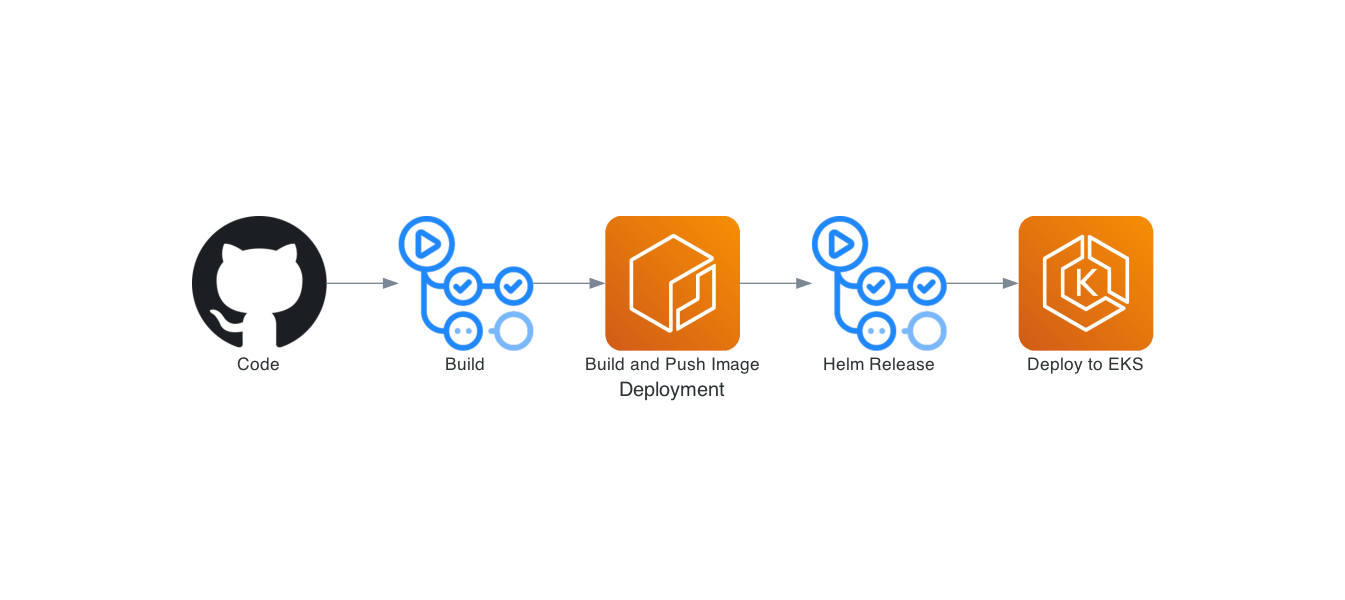

In [5]:
%%capture --no-display

from diagrams import Diagram, Cluster
from diagrams.aws.compute import EC2, ECR, EKS

from diagrams.onprem.vcs import Github
from diagrams.onprem.ci import GithubActions

with Diagram("Deployment", show=False) as diag:
        Github("Code") >> GithubActions("Build") >> ECR("Build and Push Image") >> GithubActions("Helm Release") >> EKS("Deploy to EKS")

diag


### App

Create a simple Flask app in `main.py`

```python
from flask import Flask

app = Flask(__name__)

@app.route("/")
def index():
    return "Hello World with Python Flask!"

app.run(host="0.0.0.0", port=81)
```

### Dockerfile

Create a `Dockerfile`

```dockerfile
FROM python:3.11

WORKDIR /app

RUN pip install Flask

CMD ["python", "main.py"]
```

### Helm Chart

Create the file `deploy.yaml`

```yaml
defaultImage: nginx:latest

redis:
  enabled: false # Enable Redis

apps:
  - name: tiphyspy
    service:
      enabled: true
      type: ClusterIP
      port: 8000
      hosts:
        - host: example.opszero.com
          paths: ["/"]
      command: ["python", "main.py"]
```



### Github Actions

Setup the following `.github/workflows/k8s.yml`


```yaml
name: Deploy

on:
  push:
    branches:
      - main

concurrency:
  group: ${{ github.workflow }}-${{ github.ref }}
  cancel-in-progress: true

jobs:
  deploy:
    name: Test, Build, Deploy
    runs-on: ubuntu-latest
    permissions:
      contents: read
      id-token: write
    env:
      ECR_REGISTRY: ${{ secrets.ECR_REGISTRY }}
      ECR_REPOSITORY: opszero
      IMAGE_TAG: ${{ github.sha }}
    steps:

    - name: Checkout
      uses: actions/checkout@v2

    - name: Configure AWS credentials
      uses: aws-actions/configure-aws-credentials@v1
      with:
        role-to-assume: ${{ secrets.AWS_ROLE_TO_ASSUME }}
        aws-region: us-west-2

    - name: Login to Amazon ECR
      id: login-ecr
      uses: aws-actions/amazon-ecr-login@v1

    - name: Build, tag, and push image to Amazon ECR
      run: |
        docker build -t $ECR_REGISTRY/$ECR_REPOSITORY:$IMAGE_TAG .
        docker push $ECR_REGISTRY/$ECR_REPOSITORY:$IMAGE_TAG
    - name: Release Production
      env:
        CLUSTER_NAME: opszero
      run: |
        aws eks update-kubeconfig --name $CLUSTER_NAME
        helm repo add tiphys https://opszero.github.io/tiphys
        helm repo update
        helm upgrade --install tiphyspy tiphys/tiphys --timeout 10m -f ./deploy.yaml
```

## Usage

Kubernetes is setup using AWS EKS.

## Dependencies

You will need to install the following dependencies:

```
brew install awscli kubectl helm
```

## Authentication

Ensure you have access to EKS which is done by adding your IAM to the EKS in the
terraform configuration.

```
KUBECONFIG=./kubeconfig aws --profile=account eks update-kubeconfig --cluster cluster-name
```

There can be multiple clusters so pick the correct cluster.  Ensure that you set
`export KUBECONFIG=./kubeconfig` to get the correct `KUBECONFIG` file. This can
be added into you .bashrc or .zshrc

## Ingress

The ingress is in its simplest form a Kubernetes LoadBalancer. Instead of what
would traditionally be this:

``` sh
DNS (i.e app.example.com) -> Kubernetes Service -> Kubernetes Pods
```

It is the following

``` sh
DNS (i.e app.example.com) -> Ingress (Public IP Address/CNAME) -> Kubernetes Service -> Kubernetes Pods
```

To break down the Ingress request cycle even further it is the following:

``` sh
DNS (i.e app.example.com) -> Ingress [Kubernetes Service -> Kubernetes Pods (Nginx) -> Kubernetes Service -> Kubernetes Pods]
```

The Ingress is just another pod such as Nginx that relays the traffic and as
such is just another pod in the system. The ingress is a helm chart and is
installed manually with the following script.

The ingress works at the DNS layer so it needs to be passed a Host to work:

``` sh
curl -k -H "Host: app.example.com" <https://a54313f35cb5b11e98bb60231b063008-2077563408.us-west-2.elb.amazonaws.com>
```

## Services

## Deployments

### Scale Down / Up

This has to be done through the deployment in the helm chart. Another way to do it is to scale down

```
num=0

kubectl scale --replicas=${num} -n <namespace> deployment/<deploymentname>
```

## Pods

### List Running Pods

``` sh
kubectl get pods -A
```

Kubernetes lets you divide your cluster into namespaces. Each namespace can have
its own set of resources. The above command lists all running pods on every
cluster. Pods in the kube-system namespace belong to Kubernetes and helps it
function.

### Describe Pods

```
kubectl describe pods <podname>
```

### “SSH”

To connect to the application look at the namespaces:

``` sh
kubectl get pods -A
kubectl exec -it -n <namespace> <pod> -c <container> -- bash
```


### Logs

``` sh
kubectl get pods -A
kubectl logs -f -n <namespace> <pod> -c <container>
```

This lets you view the logs of the running pod. The container running on the pod
should be configured to output logs to STDOUT/STDERR.


### Restart a Pod

If you pod is not responding or needs a restart the way to do it is to use the
following command. This will delete the pod and replace it with a new pod if it
is a part of a deployment.

```
kubectl delete pod <pod-name>
```

### Pod Issues

A pod can have various different errors. The common ones are:

 - OOMError: The pod or underlying node ran out of memory and killed the pod.
 - CrashLoopBackup: The application itself has an issue, use `kubectl logs -f <pod>` to find out why
 - ImageNotFound: The docker image for the pod can't be found.

## Troubleshooting

### Restart Nodes

Restarting nodes may need to happen if you need to change the size of the
instance, the machine's disk gets full, or you need to update a new AMI.  The
following code provides the howto.

```
export AWS_PROFILE=aws_profile
export KUBECONFIG=./kubeconfig

for i in $(kubectl get nodes | awk '{print $1}' | grep -v NAME)
do
        kubectl drain --ignore-daemonsets --grace-period=60 --timeout=30s --force $i
        aws ec2 terminate-instances --instance-ids $(aws ec2 describe-instances --filter "Name=private-dns-name,Values=${i}" | jq -r '.Reservations[].Instances[].InstanceId')
        sleep 300 # Wait 5 mins for the new machine to come back up
done
```

### List Cluster Resources

CRDs (Customer Resource Definitions) are an important part of this.
As Kubernetes deprecates the API versions you may be installing a resource that no longer is supported.

```
kubectl api-resources
```
